In [9]:
import yfinance as yf

ticker = yf.Ticker("KCHOL.IS")  #
df = ticker.history(period="5y")  # 5 years of OHLCV
df.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-09-04 00:00:00+03:00,12.501771,12.646546,12.459189,12.603965,10062045,0.0,0.0
2020-09-07 00:00:00+03:00,12.655063,12.731709,12.629515,12.714677,6163343,0.0,0.0
2020-09-08 00:00:00+03:00,12.765772,12.774288,12.510286,12.535835,8342097,0.0,0.0
2020-09-09 00:00:00+03:00,12.569901,12.620997,12.493255,12.620997,12379362,0.0,0.0
2020-09-10 00:00:00+03:00,12.672095,12.731708,12.578417,12.672095,13612705,0.0,0.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
!pip install stable_baselines3 --quiet

In [ ]:
# Ensure dividends & splits are there
print(df[['Close','Dividends','Stock Splits']].tail(10))

# Step 1: Start with a factor column = 1.0
df['AdjFactor'] = 1.0

# Step 2: Apply stock splits (backward adjustment)
for i in range(len(df)):
    split = df['Stock Splits'].iloc[i]
    if split != 0:  # e.g., 2.0 for 2-for-1
        ratio = 1.0 / split
        df.loc[:df.index[i], 'AdjFactor'] *= ratio

# Step 3: Apply dividends (backward adjustment)
# We scale all earlier prices to simulate reinvestment
for i in range(len(df)):
    dividend = df['Dividends'].iloc[i]
    if dividend != 0:
        close_price = df['Close'].iloc[i]
        ratio = (close_price - dividend) / close_price
        df.loc[:df.index[i], 'AdjFactor'] *= ratio

# Step 4: Adjusted Close = Close * cumulative adjustment factor
df['AdjClose'] = df['Close'] * df['AdjFactor']

df.to_csv("KCHOL_Adjusted.csv")

print(df[['Close','Dividends','Stock Splits','AdjClose']].head(20))

                                Close  Dividends  Stock Splits
Date                                                          
2025-08-22 00:00:00+03:00  186.300003        0.0           0.0
2025-08-25 00:00:00+03:00  189.100006        0.0           0.0
2025-08-26 00:00:00+03:00  190.399994        0.0           0.0
2025-08-27 00:00:00+03:00  185.800003        0.0           0.0
2025-08-28 00:00:00+03:00  184.800003        0.0           0.0
2025-08-29 00:00:00+03:00  183.300003        0.0           0.0
2025-09-01 00:00:00+03:00  184.100006        0.0           0.0
2025-09-02 00:00:00+03:00  172.300003        0.0           0.0
2025-09-03 00:00:00+03:00  167.899994        0.0           0.0
2025-09-04 00:00:00+03:00  170.199997        0.0           0.0
                               Close  Dividends  Stock Splits   AdjClose
Date                                                                    
2020-09-04 00:00:00+03:00  12.603966        0.0           0.0  10.585043
2020-09-07 00:00:00+03:00

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TradingEnv(gym.Env):
    def __init__(self, df, window_size=30, initial_balance=10000):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.initial_balance = initial_balance

        # State: OHLCV window (you can also add balance/positions later)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(window_size, df.shape[1]), dtype=np.float32
        )

        # Actions: 0=hold, 1=buy, 2=sell
        self.action_space = spaces.Discrete(3)

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = self.window_size
        obs = self._get_obs()
        info = {}
        return obs, info

    def _get_obs(self):
        return self.df.iloc[self.current_step - self.window_size:self.current_step].values

    def step(self, action):
        price = self.df.iloc[self.current_step]["Close"]

        # Execute action
        if action == 1:  # buy
            self.shares_held += self.balance / price
            self.balance = 0
        elif action == 2:  # sell
            self.balance += self.shares_held * price
            self.shares_held = 0

        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        truncated = False  # could use max steps cutoff

        # Reward = change in portfolio value (incremental)
        portfolio_value = self.balance + self.shares_held * price
        reward = portfolio_value - self.initial_balance

        obs = self._get_obs()
        info = {"portfolio_value": portfolio_value}

        return obs, reward, terminated, truncated, info


In [ ]:
# ===============================
# Split Data
# ===============================
train_df = df.loc[(df.index < df.index[int(len(df)*0.73)])]  # ~2010–2018
val_df   = df.loc[(df.index >= df.index[int(len(df)*0.73)]) & (df.index < df.index[int(len(df)*0.88)])]  # ~2018–2020
test_df  = df.loc[(df.index >= df.index[int(len(df)*0.88)])]  # ~2020–2022

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

Train: (913, 9) Val: (187, 9) Test: (151, 9)


In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO

# ===============================
# Train Multiple Models
# ===============================
def evaluate_model(model, env):
    obs, info = env.reset()
    done, truncated = False, False
    rewards = []
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        rewards.append(reward)
    return info["portfolio_value"]

train_env = TradingEnv(train_df)
val_env   = TradingEnv(val_df)

# Try different hyperparameters
hyperparams_list = [
    {"learning_rate": 3e-4, "n_steps": 2048},
    {"learning_rate": 1e-4, "n_steps": 1024},
    {"learning_rate": 5e-4, "n_steps": 4096},
]

best_val_score = -np.inf
best_model = None
best_params = None

for i, params in enumerate(hyperparams_list):
    print(f"\n=== Training model {i+1} with {params} ===")
    model = PPO("MlpPolicy", train_env, verbose=0, **params)
    model.learn(total_timesteps=100_000)

    val_score = evaluate_model(model, val_env)
    print(f"Validation portfolio value: {val_score:.2f}")

    if val_score > best_val_score:
        best_val_score = val_score
        best_model = model
        best_params = params

print(f"\n✅ Best model params: {best_params}, Val Score = {best_val_score:.2f}")

# ===============================
# 5. Test Best Model
# ===============================
test_env = TradingEnv(test_df)
test_score = evaluate_model(best_model, test_env)
print(f"📊 Test (Backtest) final portfolio value: {test_score:.2f}")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.



=== Training model 1 with {'learning_rate': 0.0003, 'n_steps': 2048} ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetim

Validation portfolio value: 7880.37

=== Training model 2 with {'learning_rate': 0.0001, 'n_steps': 1024} ===
Validation portfolio value: 8802.57

=== Training model 3 with {'learning_rate': 0.0005, 'n_steps': 4096} ===
Validation portfolio value: 8382.15

✅ Best model params: {'learning_rate': 0.0001, 'n_steps': 1024}, Val Score = 8802.57
📊 Test (Backtest) final portfolio value: 10686.35


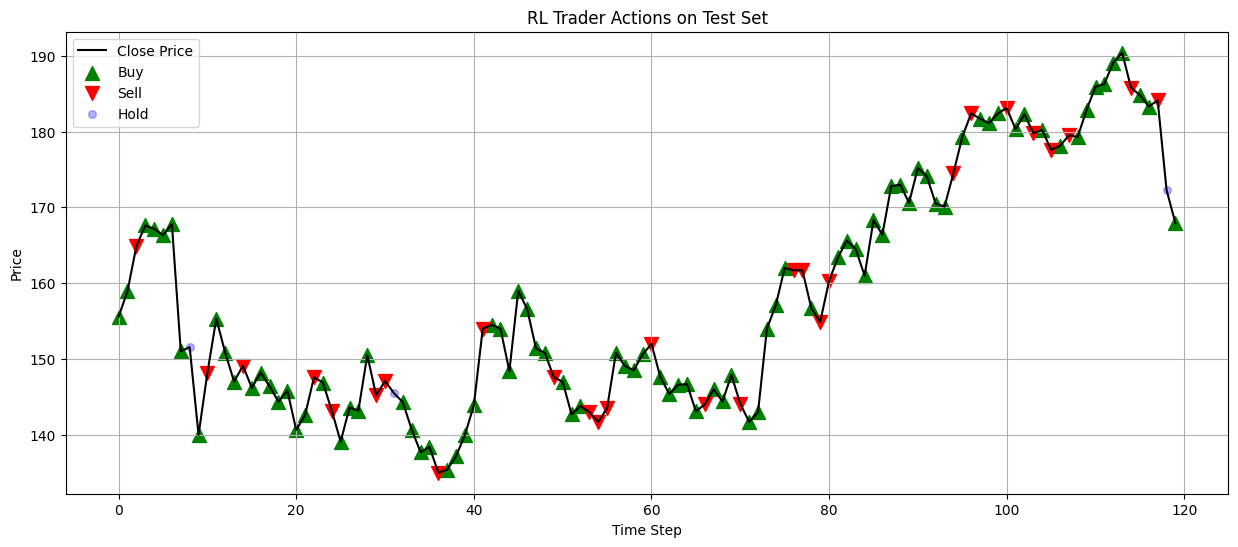

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you already have:
# - test_df (OHLCV DataFrame)
# - best_model (trained RL agent)
# - TradingEnv class

# ===============================
# 1. Run the agent on test data
# ===============================
test_env = TradingEnv(test_df)
obs, info = test_env.reset()
done, truncated = False, False

actions = []
portfolio_values = []
prices = []

while not (done or truncated):
    action, _ = best_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = test_env.step(action)

    actions.append(action)
    portfolio_values.append(info["portfolio_value"])
    prices.append(test_env.df.iloc[test_env.current_step-1]["AdjClose"])

# Convert lists to arrays for easier plotting
actions = np.array(actions)
prices = np.array(prices)

# ===============================
# 2. Prepare markers/colors
# ===============================
buy_idx  = np.where(actions == 1)[0]
sell_idx = np.where(actions == 2)[0]
hold_idx = np.where(actions == 0)[0]

# ===============================
# 3. Plot price + actions
# ===============================
plt.figure(figsize=(15,6))
plt.plot(prices, color='black', label='Close Price')

# Plot buy/sell/hold with different markers/colors
plt.scatter(buy_idx, prices[buy_idx], marker='^', color='green', s=100, label='Buy')
plt.scatter(sell_idx, prices[sell_idx], marker='v', color='red', s=100, label='Sell')
plt.scatter(hold_idx, prices[hold_idx], marker='o', color='blue', s=30, alpha=0.3, label='Hold')

plt.title("RL Trader Actions on Test Set")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
